In [1]:
#### Import librairies
import sys
import os
import time
import numpy as np
import pandas as pd
import warnings
import healpy as hp
from astropy.table import Table


sys.path.insert(0, '../script/')
import cutout_img_dc2, utils

import FoFCatalogMatching
import GCRCatalogs
import lsst.geom
import lsst.daf.persistence as dafPersist

In [2]:
tract = str(4232)# str(sys.argv[1]) # test: 4855 # training: 5074 # validation: 4637
training_test_val = '/training_24.5_v2'#str(sys.argv[2]) # test, training, validation
N = int(10000) # Usually 10 000 images per file
mag_cut = str(24.5) # 24.5 or 26.5

# Read in the observed galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd')

# Read in the truth galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

# Let's define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < '+str(mag_cut)]

# Load ra and dec from object, using both of the filters we just defined.
object_data = gc_obs.get_quantities(['ra', 'dec', 'blendedness', 'snr_r_cModel',
                                    'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2',
                                    'mag_r_cModel'],
                filters=(mag_filters), native_filters=['tract == '+str(tract)]) # test: 4855 # training: 4438 #5074 # validation: 4637

# Match the corresponding area for the truth catalog
max_ra = np.nanmax(object_data['ra'])
min_ra = np.nanmin(object_data['ra'])
max_dec = np.nanmax(object_data['dec'])
min_dec = np.nanmin(object_data['dec'])
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

# Define a mag cut for truth catalog 
truth_mag_filters = ['mag_r < '+str(mag_cut)]

# Load wanted quantities from truth catalog (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)
quantities = ['galaxy_id', 'ra', 'dec', 
              'redshift', 'redshift_true',
              'mag_r_lsst',
              'ellipticity_1_true', 'ellipticity_2_true',
              'convergence',
              'shear_1', 'shear_2']
truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.
results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=0.1, # Linking length of 1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)

## Create a list of (ra,dec) of the wanted galaxies
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))

# Create butlers catalog for accessing images
repo_grizy = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
repo_u = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-u'

butler_grizy = dafPersist.Butler(repo_grizy)
butler_u = dafPersist.Butler(repo_u)

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs-1.0.1-py3.7.egg/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs-1.0.1-py3.7.egg/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [3]:
# Create the numpy arrays
t_3 = time.time()

img_sample = np.zeros((N,59,59,6))
psf_sample = np.zeros((N,59,59,6))


indices = np.random.choice(list(range(len(truth_idx))), size=N, replace=False)

def gen_function(indices):
    np.random.seed() # important for multiprocessing !
    e1 = []
    e2 = []
    hsm_e1 = []
    hsm_e2 = []
    shear1=[]
    shear2=[]
    redshift=[]
    idx = []
    blend = []
    redshift_true=[]
    convergence=[]
    snr = []
    mag_r_meas = []
    mag_r_true = []
    i = np.random.choice(indices)
    print(i)
    first = id_ra_dec[object_idx[i]]
    ra, dec = first['ra'], first['dec']

    img = np.zeros((59,59,6))
    psf = np.zeros((59,59,6))
    filters = ['u','g','r','i','z','y']
    for k, filter_k in enumerate (filters):
        if k == 0:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_u, ra, dec, filter=filter_k)
        else:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_grizy, ra, dec, filter=filter_k)
        
        radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
        xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D
        
        img[:,:,k]= cutout.image.array
        if (cutout.getPsf().computeKernelImage(xy).array.size != 3481):
            print('not taken into account')
            break
        else:
            psf[:,:,k]= cutout.getPsf().computeKernelImage(xy).array
        
        
    idx.append(truth_data['galaxy_id'][truth_idx[i]])
    e1.append(truth_data['ellipticity_1_true'][truth_idx[i]])
    e2.append(truth_data['ellipticity_2_true'][truth_idx[i]])
    hsm_e1.append(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]])
    hsm_e2.append(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]])
    shear1.append(truth_data['shear_1'][truth_idx[i]])
    shear2.append(truth_data['shear_2'][truth_idx[i]])
    redshift.append(truth_data['redshift'][truth_idx[i]])
    blend.append(object_data['blendedness'][object_idx[i]])
    snr.append(object_data['snr_r_cModel'][object_idx[i]])
    redshift_true.append(truth_data['redshift_true'][truth_idx[i]])
    convergence.append(truth_data['convergence'][truth_idx[i]])
    mag_r_meas.append(object_data['mag_r_cModel'][object_idx[i]])
    mag_r_true.append(truth_data['mag_r_lsst'][truth_idx[i]])
    
    return img, psf, idx, e1, e2, hsm_e1, hsm_e2, shear1, shear2, redshift, blend, snr, convergence, redshift_true, mag_r_meas, mag_r_true
img_sample = []
psf_sample = []

In [4]:
t_3 = time.time()
# Here we save data for all datasets
res = utils.apply_ntimes(gen_function, N, ([indices]))
#res = []
#for k,i in enumerate(indices):
#    res.append(gen_function(i))

e1 = []
e2 = []
hsm_e1 = []
hsm_e2 = []
shear1=[]
shear2=[]
redshift=[]
idx = []
blend = []
redshift_true=[]
convergence=[]
snr = []
mag_r_meas = []
mag_r_true = []
for i in range (N):#
    img_temp, psf_temp, idx_temp, e1_temp, e2_temp, hsm_e1_temp, hsm_e2_temp, shear1_temp, shear2_temp, redshift_temp, blend_temp, snr_temp, convergence_temp,redshift_true_temp, mag_r_meas_temp, mag_r_true_temp = res[i]#utils.apply_ntimes(gen_function, N, i)#
    idx.append(idx_temp)
    e1.append(e1_temp)
    e2.append(e2_temp)
    hsm_e1.append(hsm_e1_temp)
    hsm_e2.append(hsm_e2_temp)
    shear1.append(shear1_temp)
    shear2.append(shear2_temp)
    redshift.append(redshift_temp)
    redshift_true.append(redshift_true_temp)
    blend.append(blend_temp)
    convergence.append(convergence_temp)
    snr.append(snr_temp)
    mag_r_meas.append(mag_r_meas_temp)
    mag_r_true.append(mag_r_true_temp)
    img_sample.append(img_temp)
    psf_sample.append(psf_temp)


t_4 = time.time()
print(np.array(idx).shape)
print(t_4-t_3)

df = pd.DataFrame()
df['id']=np.array(idx)[:,0] # Galaxy index in truth catalog
df['e1']=np.array(e1)[:,0] # True ellipticity before lensing
df['e2']=np.array(e2)[:,0] # True ellipticity before lensing
df['shear_1']=np.array(shear1)[:,0] # True shear applied
df['shear_2']=np.array(shear2)[:,0] # True shear applied
df['redshift']=np.array(redshift)[:,0] # Cosmological redshift with line-of-sight motion
df['redshift_true']=np.array(redshift_true)[:,0] # Cosmological redshift
df['blendedness']=np.array(blend)[:,0] # blendedness
df['snr_r']=np.array(snr)[:,0] # Signal to noise ratio in r-band
df['convergence']=np.array(convergence)[:,0] # Shear convergence
df['e1_hsm_regauss']=np.array(hsm_e1)[:,0] # e1 parameter measured with HSM REGAUSS method
df['e2_hsm_regauss']=np.array(hsm_e2)[:,0] # e2 parameter measured with HSM REGAUSS method
df['mag_r_meas']=np.array(mag_r_meas)[:,0] # Magnitude measured on image by LSST pipeline
df['mag_r_true']=np.array(mag_r_true)[:,0] # Magnitude in input of simulation

92914
8769222427

94250
4355532795
91916
67662

76287
29232
61632
30016
19210
96338
11063
72473
82187
12461
10877
28934
55617
97691
2596
47244
54427
84676
21440
49862
48778
67295
51778
93479
47728
20617
41587
80833
62260
33794
34610
5646
43501
44148
2260
81960
65822
7329
24034
75269
55336
19334
46765
92059
57808
13241
69308
72294
41101
72733
32952
1559
900
79446
31982
85553
85309
51215
33968
75607
17139
15066
5214
68130
59049
83314
75239
34211
79564
3152
97958
37434
3095
78499
54976
71293
99054
24367
45188
26425
65998
75339
13241
67403
11466
38992
48176
18509
75434
96347
56348
89013
4428
72943
6078
93841
24880
20578
25526
96864
45496
6859
23392
74906
61825
20661
77725
1851
84292
87745
62665
66480
86711
4685
45629
9507
95387
90129
30867
50659
41565
78848
60120
99783
16286
95719
72932
49913
56200
79085
17714
21305
13274
64296
98614
16171
13507
27267
7203
31401
62020
960
14721
56188
61310
46695
10702
64189
97485
85553
47825
6306
12282
64908
2906
95443
29411
33631
95878
41849
99572
88083
5

In [6]:
# Save the arrays
data_dir = '/pbs/home/b/barcelin/sps_link/data/dc2_test'#str(os.environ.get('IMGEN_DC2_DATA'))
np.save(data_dir+'/training_24.5_v2/img_sample_5.npy', img_sample)
np.save(data_dir+'/training_24.5_v2/psf_sample_5.npy', psf_sample)
df.to_csv(data_dir+'/training_24.5_v2/img_data_5.csv', index=False)

In [43]:
test_training_data = pd.read_csv(data_dir+'/training_24.5_v2/img_data_6.csv')
test_validation_data = pd.read_csv(data_dir+'/validation_24.5_v2/img_data_2.csv')

test_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   e1              10000 non-null  float64
 2   e2              10000 non-null  float64
 3   shear_1         10000 non-null  float64
 4   shear_2         10000 non-null  float64
 5   redshift        10000 non-null  float64
 6   redshift_true   10000 non-null  float64
 7   blendedness     10000 non-null  float64
 8   snr_r           9992 non-null   float64
 9   convergence     10000 non-null  float64
 10  e1_hsm_regauss  9991 non-null   float64
 11  e2_hsm_regauss  9991 non-null   float64
 12  mag_r_meas      9992 non-null   float64
 13  mag_r_true      10000 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.1 MB


In [25]:
test_validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   e1              10000 non-null  float64
 2   e2              10000 non-null  float64
 3   shear_1         10000 non-null  float64
 4   shear_2         10000 non-null  float64
 5   redshift        10000 non-null  float64
 6   redshift_true   10000 non-null  float64
 7   blendedness     10000 non-null  float64
 8   snr_r           9997 non-null   float64
 9   convergence     10000 non-null  float64
 10  e1_hsm_regauss  9982 non-null   float64
 11  e2_hsm_regauss  9982 non-null   float64
 12  mag_r_meas      9997 non-null   float64
 13  mag_r_true      10000 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.1 MB


In [26]:
import matplotlib.pyplot as plt

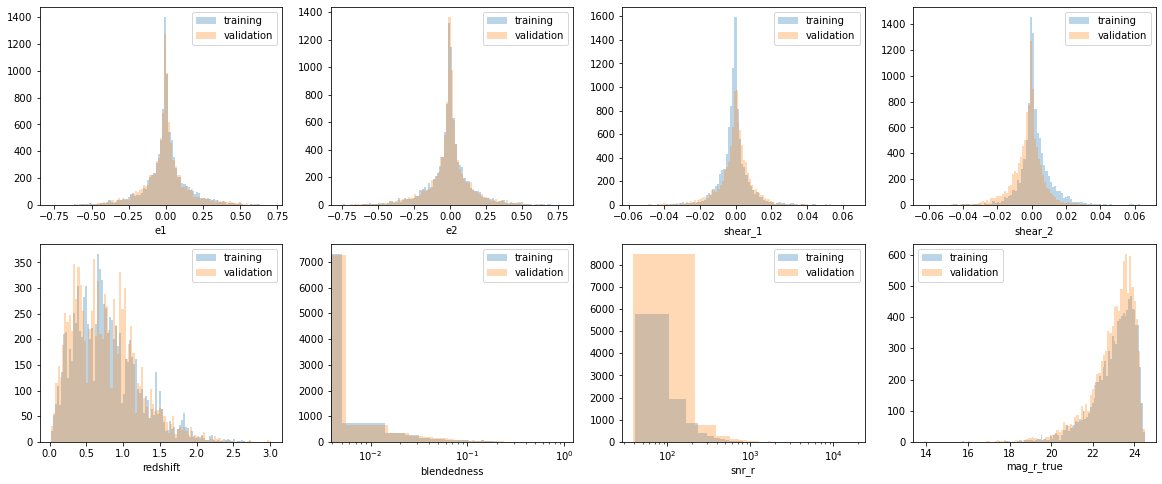

In [27]:
fig, axes = plt.subplots(2,4, figsize =(20,8))
entries = ['e1','e2','shear_1','shear_2','redshift','blendedness','snr_r','mag_r_true']

for i in range (2):
    for j in range (4):
        if (i*4+j==5) or (i*4+j==6):
            axes[i,j].set_xscale('log')
        _ = axes[i,j].hist(test_training_data[entries[i*4+j]], bins = 100, alpha = 0.3, label = 'training')
        _ = axes[i,j].hist(test_validation_data[entries[i*4+j]], bins = 100, alpha = 0.3, label = 'validation')
        axes[i,j].set_xlabel(entries[i*4+j])
        axes[i,j].legend()

In [35]:
test_training_data = pd.read_csv(data_dir+'/training_24.5_v2/img_data_1.csv')
test_validation_data = pd.read_csv(data_dir+'/training_24.5_v2/img_data_5.csv')

test_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   e1              10000 non-null  float64
 2   e2              10000 non-null  float64
 3   shear_1         10000 non-null  float64
 4   shear_2         10000 non-null  float64
 5   redshift        10000 non-null  float64
 6   redshift_true   10000 non-null  float64
 7   blendedness     10000 non-null  float64
 8   snr_r           9999 non-null   float64
 9   convergence     10000 non-null  float64
 10  e1_hsm_regauss  9992 non-null   float64
 11  e2_hsm_regauss  9992 non-null   float64
 12  mag_r_meas      9999 non-null   float64
 13  mag_r_true      10000 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.1 MB


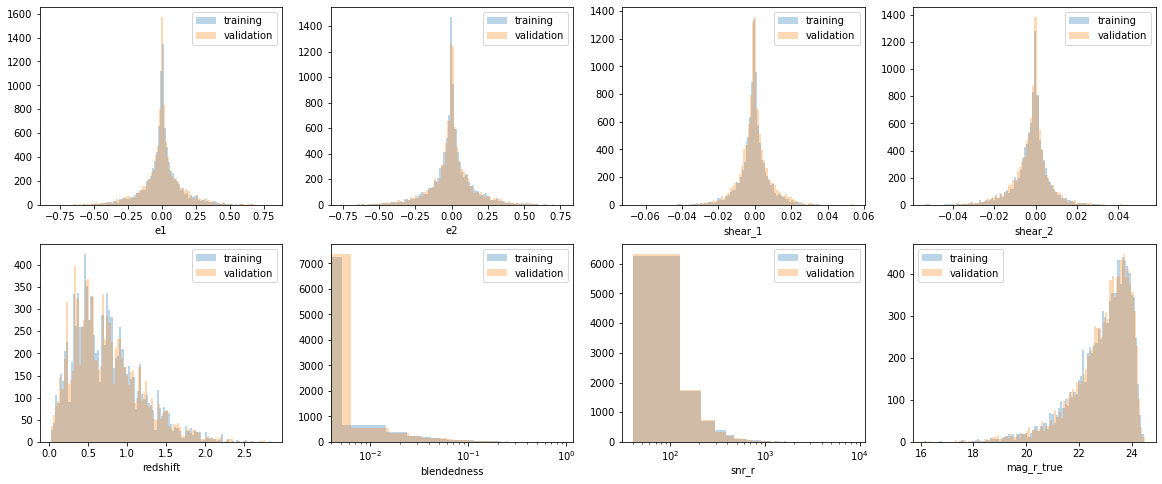

In [36]:
fig, axes = plt.subplots(2,4, figsize =(20,8))
entries = ['e1','e2','shear_1','shear_2','redshift','blendedness','snr_r','mag_r_true']

for i in range (2):
    for j in range (4):
        if (i*4+j==5) or (i*4+j==6):
            axes[i,j].set_xscale('log')
        _ = axes[i,j].hist(test_training_data[entries[i*4+j]], bins = 100, alpha = 0.3, label = 'training')
        _ = axes[i,j].hist(test_validation_data[entries[i*4+j]], bins = 100, alpha = 0.3, label = 'validation')
        axes[i,j].set_xlabel(entries[i*4+j])
        axes[i,j].legend()

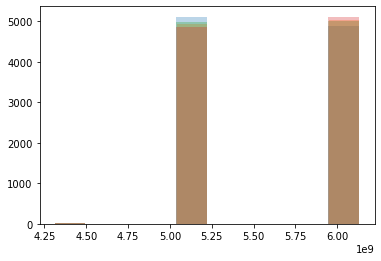

In [47]:
test_1 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_1.csv')
test_2 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_2.csv')
test_3 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_3.csv')
test_4 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_4.csv')

_ = plt.hist(test_1["id"], alpha = 0.3, label = '1')
_ = plt.hist(test_2["id"], alpha = 0.3, label = '2')
_ = plt.hist(test_3["id"], alpha = 0.3, label = '3')
_ = plt.hist(test_4["id"], alpha = 0.3, label = '4')

In [61]:
test = [test_1,test_2,test_3,test_4]

c_list = []

for z in range (10000):
    c=0
    for i,t in enumerate (test):
        for k in range (len(t)):
            if t['id'][k]==test_1['id'][z]:
                c+=1
                print(True)
    print(c)
    c_list.append(c)

True
True
2
True
True
True
3
True
True
True
3
True
True
True
3
True
True
2
True
True
True
True
4
True
1
True
True
True
3
True
True
2
True
True
True
True
4
True
1
True
True
True
True
4
True
True
True
True
4
True
True
2
True
1
True
True
True
True
4
True
True
2
True
True
True
True
True
True
6
True
True
2
True
1
True
True
True
3
True
True
2
True
True
2
True
True
2
True
True
2
True
True
2
True
True
True
True
4
True
True
True
True
True
5
True
1
True
True
2
True
1
True
True
True
True
4
True
True
True
3
True
1
True
1
True
True
True
True
4
True
1
True
True
2
True
1
True
1
True
True
True
True
4
True
True
2
True
True
True
True
True
True
6
True
True
True
True
True
True
True
7
True
True
True
True
4
True
1
True
True
2
True
True
True
True
4
True
1
True
True
2
True
1
True
1
True
True
2
True
True
2
True
True
True
3
True
True
True
3
True
True
2
True
1
True
True
True
3
True
True
True
3
True
True
True
3
True
True
2
True
True
2
True
True
True
3
True
True
True
3
True
1
True
True
True
True
4
True
True
2
True

In [62]:
np.mean(c_list)

2.2816

In [67]:
validation_1 = pd.read_csv(data_dir+'/validation_24.5_v2/img_data_1.csv')
validation_2 = pd.read_csv(data_dir+'/validation_24.5_v2/img_data_2.csv')

training_1 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_1.csv')
training_2 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_2.csv')
training_3 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_3.csv')
training_4 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_4.csv')
training_5 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_5.csv')
training_6 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_6.csv')
training_7 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_7.csv')
training_8 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_8.csv')
training_9 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_9.csv')
training_10 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_10.csv')
training_11 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_11.csv')
training_12 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_12.csv')

validation_data = pd.DataFrame()
validation_data = pd.concat([validation_1, validation_2], ignore_index=True, sort = True)

training_data = pd.DataFrame()
training_data = pd.concat([training_1, training_2, training_3, training_4, training_5, training_6, training_7, training_8, training_9, training_10, training_11, training_12], ignore_index=True, sort = True)


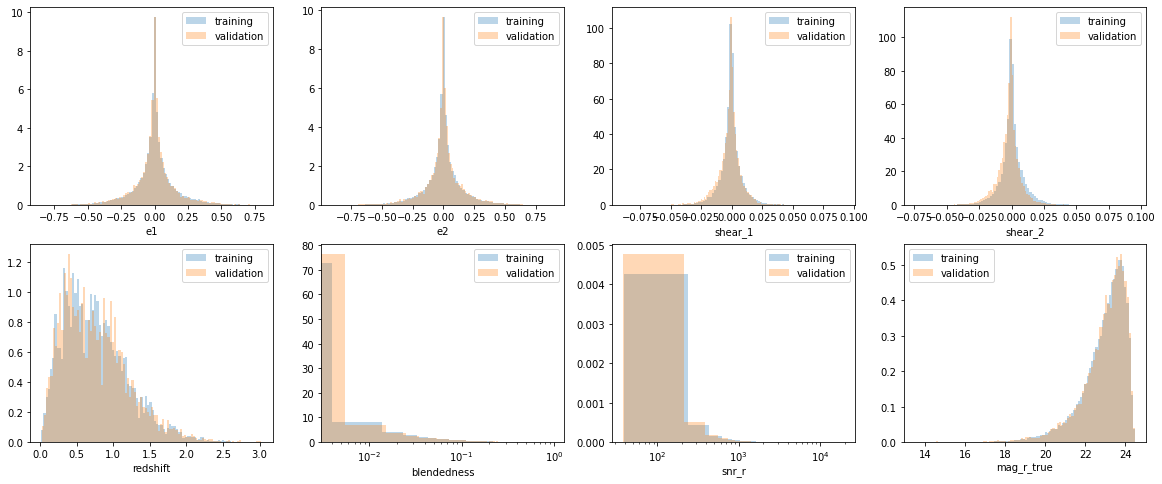

In [68]:
fig, axes = plt.subplots(2,4, figsize =(20,8))
entries = ['e1','e2','shear_1','shear_2','redshift','blendedness','snr_r','mag_r_true']

for i in range (2):
    for j in range (4):
        if (i*4+j==5) or (i*4+j==6):
            axes[i,j].set_xscale('log')
        _ = axes[i,j].hist(training_data[entries[i*4+j]], bins = 100, density = True, alpha = 0.3, label = 'training')
        _ = axes[i,j].hist(validation_data[entries[i*4+j]], bins = 100, density = True, alpha = 0.3, label = 'validation')
        axes[i,j].set_xlabel(entries[i*4+j])
        axes[i,j].legend()

In [76]:
validation_1 = pd.read_csv(data_dir+'/validation_24.5_v2/img_data_1.csv')
validation_2 = pd.read_csv(data_dir+'/validation_24.5_v2/img_data_2.csv')

training_1 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_111.csv')
training_2 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_222.csv')
training_3 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_333.csv')
training_4 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_444.csv')
training_5 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_5.csv')
training_6 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_666.csv')
training_7 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_555.csv')
training_8 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_8.csv')
#training_9 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_9.csv')
training_10 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_10.csv')
#training_11 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_11.csv')
#training_12 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_12.csv')

validation_data = pd.DataFrame()
validation_data = pd.concat([validation_1, validation_2], ignore_index=True, sort = True)

training_data = pd.DataFrame()
training_data = pd.concat([training_1, training_2, training_3, training_4, training_5, training_6, training_7, training_8, training_10], ignore_index=True, sort = True)


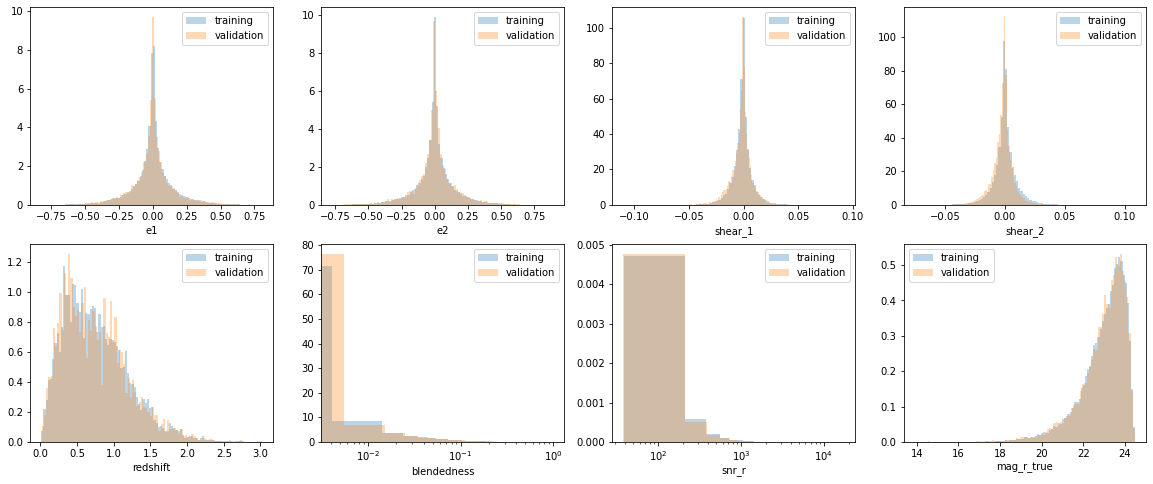

In [77]:
fig, axes = plt.subplots(2,4, figsize =(20,8))
entries = ['e1','e2','shear_1','shear_2','redshift','blendedness','snr_r','mag_r_true']

for i in range (2):
    for j in range (4):
        if (i*4+j==5) or (i*4+j==6):
            axes[i,j].set_xscale('log')
        _ = axes[i,j].hist(training_data[entries[i*4+j]], bins = 100, density = True, alpha = 0.3, label = 'training')
        _ = axes[i,j].hist(validation_data[entries[i*4+j]], bins = 100, density = True, alpha = 0.3, label = 'validation')
        axes[i,j].set_xlabel(entries[i*4+j])
        axes[i,j].legend()

In [84]:
test_data = pd.read_csv(data_dir+'/test_24.5_v2/img_data_2.csv')

training_1 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_111.csv')
training_2 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_222.csv')
training_3 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_333.csv')
training_4 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_444.csv')
training_5 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_1.csv')
training_6 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_666.csv')
training_7 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_555.csv')
training_8 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_6.csv')
#training_9 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_9.csv')
training_10 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_10.csv')
#training_11 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_11.csv')
#training_12 = pd.read_csv(data_dir+'/training_24.5_v2/img_data_12.csv')


training_data = pd.DataFrame()
training_data = pd.concat([training_1, training_2, training_3, training_4, training_5, training_6, training_7, training_8, training_10], ignore_index=True, sort = True)


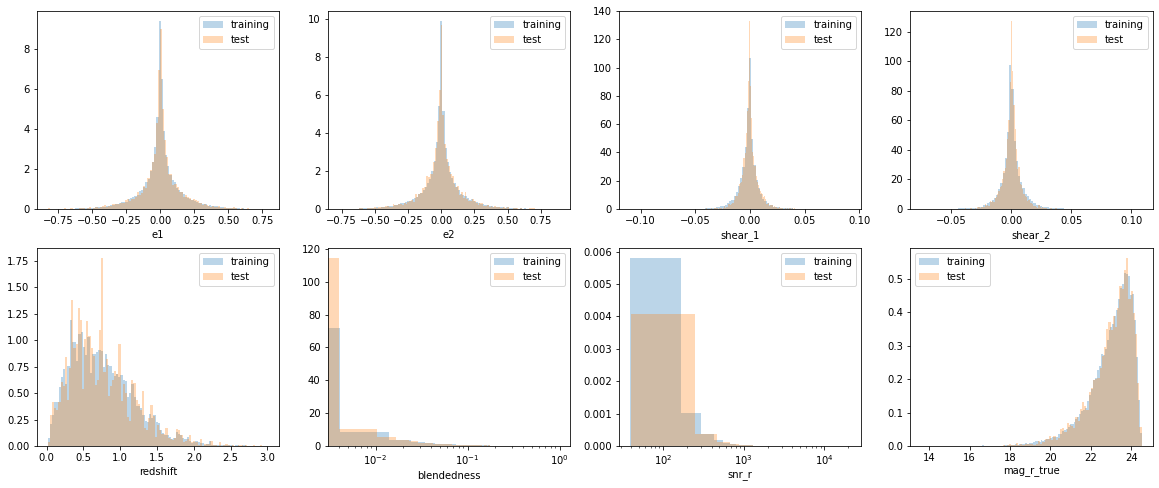

In [86]:
fig, axes = plt.subplots(2,4, figsize =(20,8))
entries = ['e1','e2','shear_1','shear_2','redshift','blendedness','snr_r','mag_r_true']

for i in range (2):
    for j in range (4):
        if (i*4+j==5) or (i*4+j==6):
            axes[i,j].set_xscale('log')
        _ = axes[i,j].hist(training_data[entries[i*4+j]], bins = 100, density = True, alpha = 0.3, label = 'training')
        _ = axes[i,j].hist(test_data[entries[i*4+j]], bins = 100, density = True, alpha = 0.3, label = 'test')
        axes[i,j].set_xlabel(entries[i*4+j])
        axes[i,j].legend()